Removing outliers seem largely inconsequential on the skew of the data as the medians tend to hover around 0 for most of the variables. Removing outliers, therefore, does not improve the skew of distributions. A more significant change may be to convert all variables to Binary Variables, given the fact that there are many 0 values in each variable any way. Based on the predictor of whether the certain type of crime occurs, or not, we may be able to gain more insight on predicting Murder.

Making all variables binary seem to result in incredibly inconsistent Rsquared values when testing on holdout groups however they score at nearly 99% on the test sample. This seems to be a sign of overfitting. Perhaps making some of the variables binary and leaving some as continuous will improve the consistency.

My thoughts for creating relevant features is to...:
1. First explore the data and decide which variables should be converted into binary variables
2. Inverse code new variables such as "safe" variables as opposed to crime variables
3. Combine variables that are highly correlated
4. Create PCAs
5. Second create log transformations on the continious predictor variables that I already have so that I can normalize the data.
6. Remove outliers by a facor of the the third quartile + 3 * the interquartile range

In [28]:
import math

from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scipy
import statsmodels.formula.api as smf
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')

In [29]:
# Read data using pandas
df = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls')

In [30]:
df.head()

,Table 8,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson3
4,Adams Village,1861,0,0,NaN,0,0,0,12,2,10,0,0


In [31]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [32]:
# Data Cleaning
# Delete first three rows
df = df.drop([0,1,2], axis=0)

# Make first row the column headers
df = df.reset_index(drop=True)
df.columns = df.iloc[0]
df = df.drop([0], axis=0)
df = df.reset_index(drop=True)

# Rename all column headers
df.columns = ['City', 'Population', 'Violent Crime', 'Murder and Nonnegligent Manslaughter', 'Rape (revised definition)', 'Rape (legacy definition)', 'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary', 'Larceny-Theft', 'Motor Vehicle Theft', 'Arson']


# Remove entire Unnamed: 4 or 'Rape revised defintion'
df = df.drop('Rape (revised definition)', axis=1)

# Remove null objects
df = df.drop([348, 349, 350], axis=0)
df = df.drop('Arson', axis=1)
df = df.dropna(how='all')

#Convert Columns from object to integer
df[['Population', 'Violent Crime',
       'Murder and Nonnegligent Manslaughter', 'Rape (legacy definition)',
       'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']] = df[['Population', 'Violent Crime',
       'Murder and Nonnegligent Manslaughter', 'Rape (legacy definition)',
       'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']].astype(int)

#Rename murder column to 'Murder'
df = df.rename(columns = {'Murder and Nonnegligent Manslaughter':'Murder'})

# Change name of Property Crime and Aggravated Assault so that it's one word
df['Propertycrime'] = df['Property Crime']
df = df.drop(columns=['Property Crime'])

df['Rape'] = df['Rape (legacy definition)']
df = df.drop(columns=['Rape (legacy definition)'])

df['Aggravated_Assault'] = df['Aggravated Assault']
df = df.drop(columns=['Aggravated Assault'])


In [33]:
df.head()

,City,Population,Violent Crime,Murder,Robbery,Burglary,Larceny-Theft,Motor Vehicle Theft,Propertycrime,Rape,Aggravated_Assault
0,Adams Village,1861,0,0,0,2,10,0,12,0,0
1,Addison Town and Village,2577,3,0,0,3,20,1,24,0,3
2,Akron Village,2846,3,0,0,1,15,0,16,0,3
3,Albany,97956,791,8,227,705,3243,142,4090,30,526
4,Albion Village,6388,23,0,4,53,165,5,223,3,16


In [34]:
df.describe()

,Population,Violent Crime,Murder,Robbery,Burglary,Larceny-Theft,Motor Vehicle Theft,Propertycrime,Rape,Aggravated_Assault
count,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000
mean,40037.632,201.595,1.566,72.902,119.684,637.017,35.905,792.606,5.865,121.261
std,450037.368,2815.269,18.304,1031.033,924.949,6346.054,403.424,7659.725,60.425,1706.132
min,526.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3003.000,2.000,0.000,0.000,6.000,31.000,0.000,40.500,0.000,1.000
50%,7233.500,6.000,0.000,1.000,17.500,94.000,2.000,112.500,0.000,4.000
75%,18427.500,22.000,0.000,5.000,51.250,287.250,7.000,341.000,2.000,14.000
max,8396126.000,52384.000,335.000,19170.000,16606.000,117931.000,7434.000,141971.000,1112.000,31767.000


Variables to convert to Binary:

1. Robbery
2. Moto Vehicle theft
3. Rape
4. Aggravated_Assault
4. Violent Crime
5. Murder

In [35]:
# Create Features: Population^2, Murder binary, Robbery, binary
# More specifically, create binary categories for murder and robery
df['Population^2'] = df['Population']**2
df['Murder'] = np.where(df['Murder']>0, '1', '0')
df['Aggravated_Assault'] = np.where(df['Aggravated_Assault']>0, '1', '0')
df['Violent Crime'] = np.where(df['Violent Crime']>0, '1', '0')
df['Rape'] = np.where(df['Rape']>0, '1', '0')
df['Robbery'] = np.where(df['Robbery']>0, '1', '0')
df['Motor Vehicle Theft'] = np.where(df['Motor Vehicle Theft']>0, '1', '0')


#Convert new columns to int
df[['Population', 'Violent Crime',
       'Murder', 'Rape',
       'Robbery', 'Aggravated_Assault', 'Propertycrime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']] = df[['Population', 'Violent Crime',
       'Murder', 'Rape', 'Robbery', 'Aggravated_Assault', 'Propertycrime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']].astype(int)

In [36]:
df.head()

,City,Population,Violent Crime,Murder,Robbery,Burglary,Larceny-Theft,Motor Vehicle Theft,Propertycrime,Rape,Aggravated_Assault,Population^2
0,Adams Village,1861,0,0,0,2,10,0,12,0,0,3463321
1,Addison Town and Village,2577,1,0,0,3,20,1,24,0,1,6640929
2,Akron Village,2846,1,0,0,1,15,0,16,0,1,8099716
3,Albany,97956,1,1,1,705,3243,1,4090,1,1,9595377936
4,Albion Village,6388,1,0,1,53,165,1,223,1,1,40806544


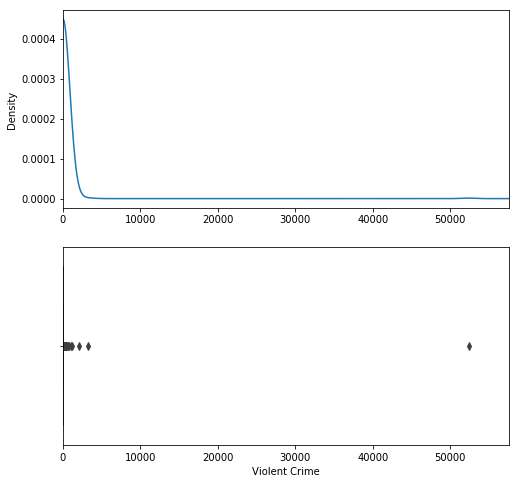

In [9]:
i = 'Violent Crime'

plt.figure(figsize=(8,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)

ax = df[i].plot(kind = 'kde')

plt.subplot(212)
plt.xlim(df[i].min(), df[i].max()*1.1)
sns.boxplot(x = df[i])

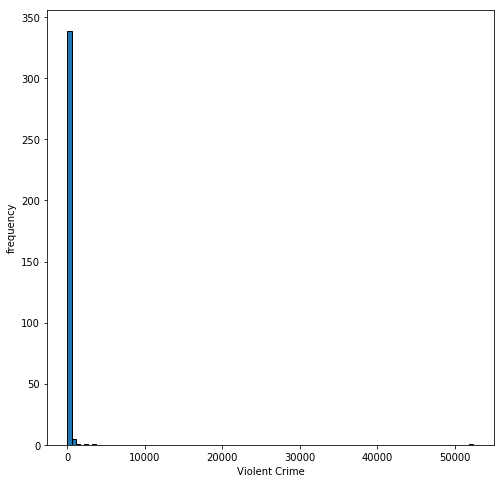

In [10]:
plt.figure(figsize=(8,8))
plt.hist(df['Violent Crime'], bins=100, edgecolor='k')
plt.xlabel('Violent Crime')
plt.ylabel('frequency')
plt.show()

In [11]:
# Remove any zeros (otherwise we get (-inf)
df.loc[df['Violent Crime'] == 0, 'Violent Crime'] = np.nan
 
# Drop NA
df.dropna(inplace=True)
 
# Log Transform
df['Log_' + i] = np.log(df[i])

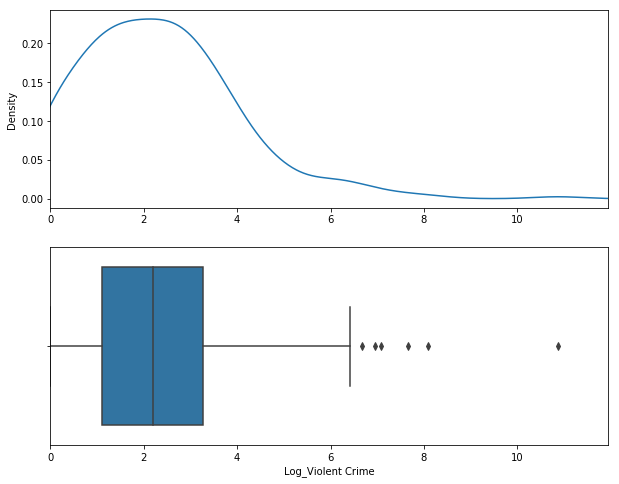

In [12]:
i = 'Log_Violent Crime'
 
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)
 
ax = df[i].plot(kind='kde')
 
plt.subplot(212)
plt.xlim(df[i].min(), df[i].max()*1.1)
sns.boxplot(x=df[i])

In [14]:
df.head()

,City,Population,Violent Crime,Murder,Robbery,Burglary,Larceny-Theft,Motor Vehicle Theft,Propertycrime,Rape,Aggravated_Assault,Log_Violent Crime,Population^2,Robbery_binary,Propertycrime
1,Addison Town and Village,2577,1,0,0,1,1,1,24,0,1,1.099,6640929,0,1
2,Akron Village,2846,1,0,0,1,1,0,16,0,1,1.099,8099716,0,1
3,Albany,97956,1,1,1,1,1,1,4090,1,1,6.673,9595377936,1,1
4,Albion Village,6388,1,0,1,1,1,1,223,1,1,3.135,40806544,1,1
5,Alfred Village,4089,1,0,1,1,1,0,46,0,1,1.609,16719921,1,1


In [15]:
# Run Model
regr = linear_model.LinearRegression()
y = df['Propertycrime'].values.reshape(-1, 1)
x = df[['Population','Population^2', 'Murder', 'Robbery_binary']]
regr.fit(x,y)

# Inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:\n', regr.score(x,y))


Coefficients: 
 [[ 3.47250309e-02 -2.11913747e-09  1.33591024e+01 -7.97411971e+01]]

Intercept: 
 [-127.28821682]

R-squared:
 0.9961342145080704


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [16]:
# Cross Validation test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print('With 30% holdout: ' + str(regr.fit(x_train, y_train).score(x_test, y_test)))
print('Testing on sample:' + str(regr.fit(x,y).score(x,y)))

With 30% holdout: -1597.3115504210907
Testing on sample:0.9961342145080704


In [17]:
# Cross-validation with mutliple folds
from sklearn.model_selection import cross_val_score

cross_val_score(regr, x, y, cv=5)

array([ 8.21817348e-01,  3.30810995e-01,  4.92307349e-01, -2.28056823e+03,
        4.49276500e-01])

In [18]:
# Test for significance in parameters
linear_formula = 'Propertycrime ~ Population+Population^2+Murder+Robbery_binary'

# Fit the model to our data using formula
lm = smf.ols(formula=linear_formula, data=df).fit()

In [19]:
lm.params

Intercept             -33.991
Robbery_binary[T.1]   108.642
Population              7.181
Population ^ 2         -7.164
Murder                607.728
dtype: float64

In [20]:
lm.pvalues

Intercept             0.638
Robbery_binary[T.1]   0.224
Population            0.715
Population ^ 2        0.716
Murder                0.000
dtype: float64

In [21]:
# Create PCA on the follwing variables: Burglary, Violent Crime, Aggravated_Assault, Larceny-Theft, Motor-Vehicle Theft, Robbery

# Standardize Data
features = ['Burglary', 'Violent Crime', 'Aggravated_Assault', 'Larceny-Theft']
x = df.loc[:, features].values

scaler = StandardScaler()

scaler.fit(x)

pd.DataFrame(data=x, columns=features).head()

# PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

# Create Merged Data Frame
principalDf = pd.DataFrame(data = principalComponents, columns = ['principalcomponent_1', 'principalcomponent_2'])
principalDf['City'] = df['City']
merged_inner = pd.merge(left=df, right=principalDf, left_on='City', right_on='City')
df = merged_inner

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [22]:
# Run Model
regr = linear_model.LinearRegression()
y = df['Propertycrime'].values.reshape(-1, 1)
x = df[['Population','Population^2', 'Murder', 'Robbery_binary', 'principalcomponent_1', 'principalcomponent_2']]
regr.fit(x,y)

# Inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:\n', regr.score(x,y))


Coefficients: 
 [[ 3.89062467e-02 -2.61584742e-09 -1.83462412e+01 -1.00736268e+02
  -6.78279255e+01  1.98431122e+02]]

Intercept: 
 [-164.59456153]

R-squared:
 0.9975191244164905


In [23]:
# Cross Validation test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
print('With 30% holdout: ' + str(regr.fit(x_train, y_train).score(x_test, y_test)))
print('Testing on sample:' + str(regr.fit(x,y).score(x,y)))

With 30% holdout: -8434.04083784341
Testing on sample:0.9975191244164905
